# Evaluation of the models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import matplotlib.dates as mdates
import requests_cache
from datetime import date, timedelta
import seaborn as sns
import numpy as np
import sys
sys.path.append("..")
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

## Load Data

In [2]:
# Load data dictionaries
import json

with open('../data/metrics.json', 'r') as f:
    metrics_dict = json.load(f)

with open('../data/prepared_data_dict.json', 'r') as f:
    ys_dict = json.load(f)

In [3]:
print(metrics_dict.keys())
print(ys_dict.keys())
print(ys_dict['Stadt Freiburg'].keys())
print(metrics_dict['Stadt Freiburg weather'].keys())

dict_keys(['Landeshauptstadt Stuttgart weather', 'Landeshauptstadt Stuttgart forecast', 'Landeshauptstadt Stuttgart both', 'Stadt Freiburg weather', 'Stadt Freiburg forecast', 'Stadt Freiburg both', 'Stadt Heidelberg weather', 'Stadt Heidelberg forecast', 'Stadt Heidelberg both', 'Stadt Ludwigsburg weather', 'Stadt Ludwigsburg forecast', 'Stadt Ludwigsburg both', 'Stadt Mannheim weather', 'Stadt Mannheim forecast', 'Stadt Mannheim both', 'Stadt Reutlingen weather', 'Stadt Reutlingen forecast', 'Stadt Reutlingen both', 'Stadt Tübingen weather', 'Stadt Tübingen forecast', 'Stadt Tübingen both'])
dict_keys(['Landeshauptstadt Stuttgart', 'Stadt Freiburg', 'Stadt Heidelberg', 'Stadt Ludwigsburg', 'Stadt Mannheim', 'Stadt Reutlingen', 'Stadt Tübingen'])
dict_keys(['y_train', 'y_test'])
dict_keys(['lambdas', 'AIC', 'edof', 'GCV', 'r2_train', 'r2_test', 'rmse_train', 'rmse_test', 'y_train_hat', 'y_test_hat'])


In [4]:
# Für jede Stadt ein Data Frame erstellen mit y_test und y_test_hat für all Modelle
model_types = [' weather', ' forecast', ' both'] 
dfs_ys = {}
for city in ys_dict.keys():
    y_test = ys_dict[city]['y_test']
    df_city = pd.DataFrame({'y_test': y_test})
    for model_type in model_types:
        key_name_model= city + model_type
        y_test_hat = metrics_dict[key_name_model]['y_test_hat']
        df_city['y_test_hat' + model_type] = y_test_hat
    dfs_ys[city] = df_city
print(dfs_ys['Stadt Freiburg'].head())


     y_test  y_test_hat weather  y_test_hat forecast  y_test_hat both
0 -0.992694           -0.327069            -0.079905        -0.274168
1 -1.000574           -0.335978            -0.316031        -0.386785
2 -1.427548           -0.071099            -0.077726        -0.078275
3 -0.498839           -0.015216            -0.054733        -0.032190
4  0.102161           -0.052005            -0.058906        -0.046250


## MAE für jede Stadt berechnen und plotten

In [5]:
# Für jedes Modell jeder Stadt den MAE berechnen und in einem Data Frame speichern
mae_results_list = []
for city in dfs_ys.keys():
    df_city = dfs_ys[city]
    for model_type in model_types:
        y_test = df_city['y_test']
        y_test_hat = df_city['y_test_hat' + model_type]
        mae = mean_absolute_error(y_test, y_test_hat)
        
        mae_results_list.append({
            'city': city,
            'model_type': model_type.strip(),
            'MAE': mae
        })

mae_results = pd.DataFrame(mae_results_list)
del mae_results_list
print(mae_results) 

                          city model_type       MAE
0   Landeshauptstadt Stuttgart    weather  0.316312
1   Landeshauptstadt Stuttgart   forecast  0.315005
2   Landeshauptstadt Stuttgart       both  0.312308
3               Stadt Freiburg    weather  0.222305
4               Stadt Freiburg   forecast  0.222452
5               Stadt Freiburg       both  0.220982
6             Stadt Heidelberg    weather  0.380677
7             Stadt Heidelberg   forecast  0.380923
8             Stadt Heidelberg       both  0.377896
9            Stadt Ludwigsburg    weather  0.315971
10           Stadt Ludwigsburg   forecast  0.314755
11           Stadt Ludwigsburg       both  0.311235
12              Stadt Mannheim    weather  0.329236
13              Stadt Mannheim   forecast  0.333205
14              Stadt Mannheim       both  0.329168
15            Stadt Reutlingen    weather  0.295184
16            Stadt Reutlingen   forecast  0.295057
17            Stadt Reutlingen       both  0.292806
18          

In [6]:
# change model_type names to observed for weather, and combined for both
mae_results['model_type'] = mae_results['model_type'].replace({'weather': 'observed', 'both': 'combined'})
print(mae_results)

                          city model_type       MAE
0   Landeshauptstadt Stuttgart   observed  0.316312
1   Landeshauptstadt Stuttgart   forecast  0.315005
2   Landeshauptstadt Stuttgart   combined  0.312308
3               Stadt Freiburg   observed  0.222305
4               Stadt Freiburg   forecast  0.222452
5               Stadt Freiburg   combined  0.220982
6             Stadt Heidelberg   observed  0.380677
7             Stadt Heidelberg   forecast  0.380923
8             Stadt Heidelberg   combined  0.377896
9            Stadt Ludwigsburg   observed  0.315971
10           Stadt Ludwigsburg   forecast  0.314755
11           Stadt Ludwigsburg   combined  0.311235
12              Stadt Mannheim   observed  0.329236
13              Stadt Mannheim   forecast  0.333205
14              Stadt Mannheim   combined  0.329168
15            Stadt Reutlingen   observed  0.295184
16            Stadt Reutlingen   forecast  0.295057
17            Stadt Reutlingen   combined  0.292806
18          

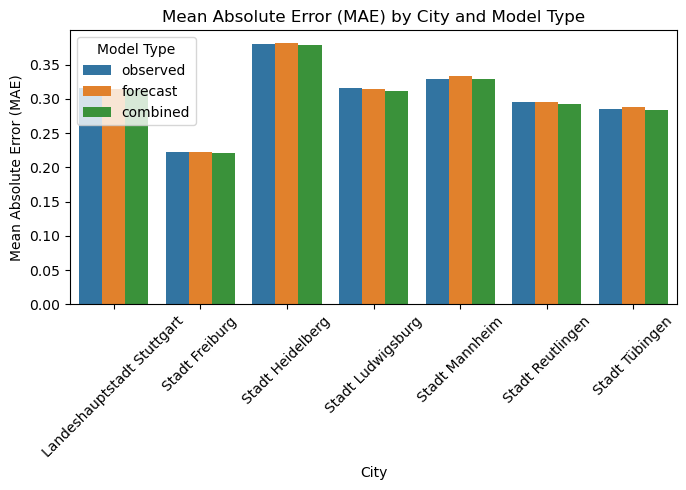

In [7]:
# MAEs plotten
plt.figure(figsize=(7, 5))
sns.barplot(data=mae_results, x='city', y='MAE', hue='model_type')
plt.title('Mean Absolute Error (MAE) by City and Model Type')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('City')
plt.legend(title='Model Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# werte sehr ähnlich zwischen den Modellen --> sinnvoll differenzen zwischen MAEs zu nehmen statt absolute werte

In [8]:
# differenzen zwischen den MAEs berechnen und in einem Data Frame speichern
mae_diff_list = []

for city in mae_results['city'].unique():
    mae_observed = mae_results[(mae_results['city'] == city) & (mae_results['model_type'] == 'observed')]['MAE'].values[0]
    mae_forecast = mae_results[(mae_results['city'] == city) & (mae_results['model_type'] == 'forecast')]['MAE'].values[0]
    mae_combined = mae_results[(mae_results['city'] == city) & (mae_results['model_type'] == 'combined')]['MAE'].values[0]

    diff_observed_forecast = mae_forecast - mae_observed
    diff_observed_combined = mae_combined - mae_observed
    diff_forecast_combined = mae_combined - mae_forecast

    # Listen erweitern statt concat
    mae_diff_list.extend([
        {'city': city, 'model_comparison': 'forecast - observed', 'MAE_difference': diff_observed_forecast},
        {'city': city, 'model_comparison': 'combined - observed', 'MAE_difference': diff_observed_combined},
        {'city': city, 'model_comparison': 'combined - forecast', 'MAE_difference': diff_forecast_combined}
    ])

# DataFrame erstellen
mae_differences = pd.DataFrame(mae_diff_list)
del mae_diff_list
print(mae_differences)

                          city     model_comparison  MAE_difference
0   Landeshauptstadt Stuttgart  forecast - observed       -0.001307
1   Landeshauptstadt Stuttgart  combined - observed       -0.004004
2   Landeshauptstadt Stuttgart  combined - forecast       -0.002697
3               Stadt Freiburg  forecast - observed        0.000148
4               Stadt Freiburg  combined - observed       -0.001323
5               Stadt Freiburg  combined - forecast       -0.001471
6             Stadt Heidelberg  forecast - observed        0.000246
7             Stadt Heidelberg  combined - observed       -0.002780
8             Stadt Heidelberg  combined - forecast       -0.003027
9            Stadt Ludwigsburg  forecast - observed       -0.001216
10           Stadt Ludwigsburg  combined - observed       -0.004736
11           Stadt Ludwigsburg  combined - forecast       -0.003520
12              Stadt Mannheim  forecast - observed        0.003969
13              Stadt Mannheim  combined - obser

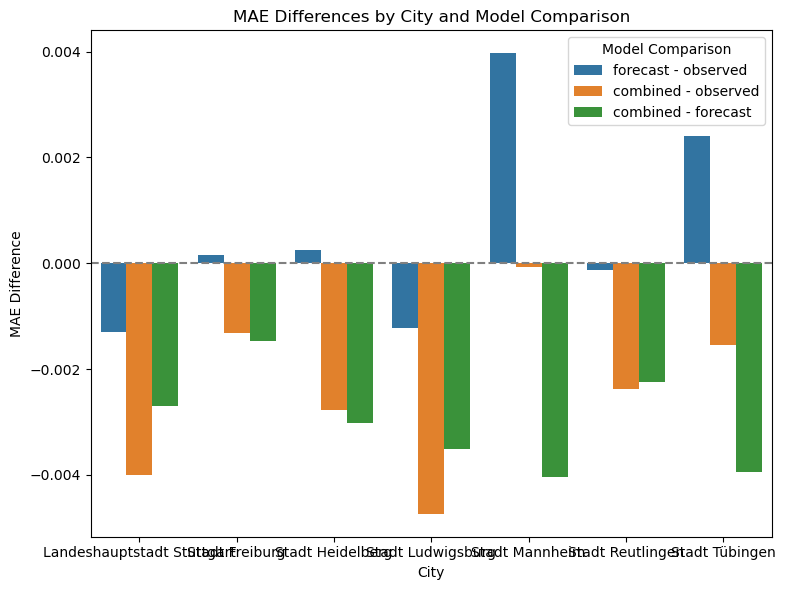

In [9]:
# MAE diffs plotten
plt.figure(figsize=(8, 6))
sns.barplot(data=mae_differences, x='city', y='MAE_difference', hue='model_comparison')
plt.title('MAE Differences by City and Model Comparison')
plt.ylabel('MAE Difference')
plt.xlabel('City')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Model Comparison')
plt.tight_layout()
plt.show()

## MAE differences with CIs

In [10]:
def block_bootstrap_ci(y_true, y_hat_obs, y_hat_fc, y_hat_comb, block_size=168, n_bootstrap=2000, confidence=0.95):
    """
    Block Bootstrap für Zeitreihen mit replacement
    block_size: 168 = 1 Woche (Stunden)
    Returns: MAE difference on the original test set, CI_lower, CI_upper per city per model comparison
    3 comparisons: forecast - observed, observed - combined, forecast - combined
    """
    n = len(y_true)
    n_blocks = int(np.ceil(n / block_size))
    
    bootstrap_diffs_fc_obs = []
    bootstrap_diffs_obs_comb = []
    bootstrap_diffs_fc_comb = []
    
    np.random.seed(42)
    
    for _ in range(n_bootstrap):
        # Zufällige Blöcke mit Replacement auswählen
        block_indices = np.random.choice(n_blocks, size=n_blocks, replace=True)
        
        # Indizes zusammensetzen
        sampled_indices = []
        for block_idx in block_indices:
            start = block_idx * block_size
            end = min(start + block_size, n)
            sampled_indices.extend(range(start, end))
        
        sampled_indices = sampled_indices[:n]
        
        # alle 3 MAEs berechnen
        mae_obs = mean_absolute_error(y_true[sampled_indices], y_hat_obs[sampled_indices])
        mae_fc = mean_absolute_error(y_true[sampled_indices], y_hat_fc[sampled_indices])
        mae_comb = mean_absolute_error(y_true[sampled_indices], y_hat_comb[sampled_indices])
        
        # Differenzen berechnen
        bootstrap_diffs_fc_obs.append(mae_fc - mae_obs)
        bootstrap_diffs_obs_comb.append(mae_obs - mae_comb)
        bootstrap_diffs_fc_comb.append(mae_fc - mae_comb)
    
    # In numpy arrays konvertieren
    diffs_fc_obs = np.array(bootstrap_diffs_fc_obs)
    diffs_obs_comb = np.array(bootstrap_diffs_obs_comb)
    diffs_fc_comb = np.array(bootstrap_diffs_fc_comb)

    # Berechnung der MAE differenzen auf dem originalen Testset
    mae_obs_orig = mean_absolute_error(y_true, y_hat_obs)
    mae_fc_orig = mean_absolute_error(y_true, y_hat_fc)
    mae_comb_orig = mean_absolute_error(y_true, y_hat_comb)
    diff_fc_obs_orig = mae_fc_orig - mae_obs_orig
    diff_obs_comb_orig = mae_obs_orig - mae_comb_orig
    diff_fc_comb_orig = mae_fc_orig - mae_comb_orig
    
    # Konfidenzintervalle
    alpha = (1 - confidence) / 2
    
    results = {
        'forecast - observed': {
            'MAE difference': diff_fc_obs_orig,
            'lower': np.percentile(diffs_fc_obs, alpha * 100),
            'upper': np.percentile(diffs_fc_obs, (1 - alpha) * 100),
        },
        'observed - combined': {
            'MAE difference': diff_obs_comb_orig,
            'lower': np.percentile(diffs_obs_comb, alpha * 100),
            'upper': np.percentile(diffs_obs_comb, (1 - alpha) * 100),
        },
        'forecast - combined': {
            'MAE difference': diff_fc_comb_orig,
            'lower': np.percentile(diffs_fc_comb, alpha * 100),
            'upper': np.percentile(diffs_fc_comb, (1 - alpha) * 100),
        }
    }
    
    return results

In [11]:
# Bootstrap CIs für jede Stadt berechnen
bootstrap_results = []

for city in dfs_ys.keys():
    df_city = dfs_ys[city]
    
    y_true = df_city['y_test'].values
    y_hat_obs = df_city['y_test_hat weather'].values
    y_hat_fc = df_city['y_test_hat forecast'].values
    y_hat_comb = df_city['y_test_hat both'].values
    
    # Bootstrap CIs berechnen
    results = block_bootstrap_ci(y_true, y_hat_obs, y_hat_fc, y_hat_comb, n_bootstrap=100) # FIXME: n_bootstrap wieder weg machen oder höher setzen
    print("completed city:", city)
    
    # Ergebnisse in Liste speichern
    for comparison, values in results.items():
        bootstrap_results.append({
            'city': city,
            'model_comparison': comparison,
            'MAE_difference': values['MAE difference'],
            'CI_lower': values['lower'],
            'CI_upper': values['upper'],
        })

bootstrap_df = pd.DataFrame(bootstrap_results)
del bootstrap_results,
print(bootstrap_df)

completed city: Landeshauptstadt Stuttgart
completed city: Stadt Freiburg
completed city: Stadt Heidelberg
completed city: Stadt Ludwigsburg
completed city: Stadt Mannheim
completed city: Stadt Reutlingen
completed city: Stadt Tübingen
                          city     model_comparison  MAE_difference  CI_lower  \
0   Landeshauptstadt Stuttgart  forecast - observed       -0.001307 -0.002096   
1   Landeshauptstadt Stuttgart  observed - combined        0.004004  0.003203   
2   Landeshauptstadt Stuttgart  forecast - combined        0.002697  0.001949   
3               Stadt Freiburg  forecast - observed        0.000148 -0.002092   
4               Stadt Freiburg  observed - combined        0.001323 -0.000205   
5               Stadt Freiburg  forecast - combined        0.001471 -0.000097   
6             Stadt Heidelberg  forecast - observed        0.000246 -0.000714   
7             Stadt Heidelberg  observed - combined        0.002780  0.001659   
8             Stadt Heidelberg  for

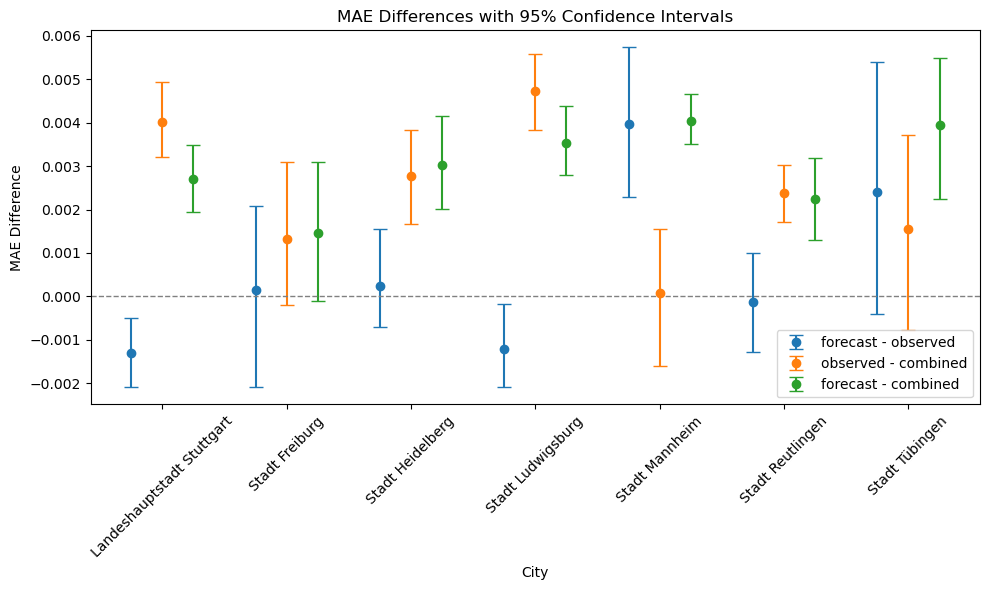

In [12]:
# Visualisierung mit Konfidenzintervallen
plt.figure(figsize=(10, 6))

for i, comparison in enumerate(['forecast - observed', 'observed - combined', 'forecast - combined']):
    data = bootstrap_df[bootstrap_df['model_comparison'] == comparison]
    x_positions = np.arange(len(data)) + i * 0.25
    
    plt.errorbar(x_positions, data['MAE_difference'], 
                 yerr=[data['MAE_difference'] - data['CI_lower'], 
                       data['CI_upper'] - data['MAE_difference']],
                 fmt='o', label=comparison, capsize=5)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(np.arange(len(data)) + 0.25, data['city'].unique(), rotation=45)
plt.ylabel('MAE Difference')
plt.xlabel('City')
plt.title('MAE Differences with 95% Confidence Intervals')
plt.legend()
plt.tight_layout()
plt.show()

## Mean von MAE über alle Städte hinweg mit bootstrap der Städte

In [13]:
comparisons = bootstrap_df['model_comparison'].unique()
results_list = []

np.random.seed(42)
n_bootstrap = 100 # FIXME: besser 2000
confidence = 0.95

for comparison in comparisons:
    MAEs_per_model = bootstrap_df[bootstrap_df['model_comparison'] == comparison]
    cities = MAEs_per_model['city'].values
    n_cities = len(cities)
    
    bootstrap_means = []
    
    for _ in range(n_bootstrap):
        # Städte mit Replacement samplen
        sampled_cities = np.random.choice(cities, size=n_cities, replace=True)
        
        # MAE-Differenzen der gesampelten Städte
        sampled_diffs = np.array([MAEs_per_model[MAEs_per_model['city'] == city]['MAE_difference'].values[0] for city in sampled_cities])
        
        # Mittelwert berechnen
        bootstrap_means.append(np.mean(sampled_diffs))
    
    bootstrap_means = np.array(bootstrap_means)
    
    # Originaler Mittelwert
    mean_diff_orig = MAEs_per_model['MAE_difference'].mean()
    
    # Konfidenzintervalle
    alpha = (1 - confidence) / 2
    ci_lower = np.percentile(bootstrap_means, alpha * 100)
    ci_upper = np.percentile(bootstrap_means, (1 - alpha) * 100)
    
    results_list.append({
        'model_comparison': comparison,
        'mean_MAE_difference': mean_diff_orig,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper,
    })

mean_differences_df = pd.DataFrame(results_list)
del results_list, bootstrap_means
print(mean_differences_df)

      model_comparison  mean_MAE_difference  CI_lower  CI_upper
0  forecast - observed             0.000588 -0.000769  0.002047
1  observed - combined             0.002405  0.001261  0.003468
2  forecast - combined             0.002992  0.002243  0.003444


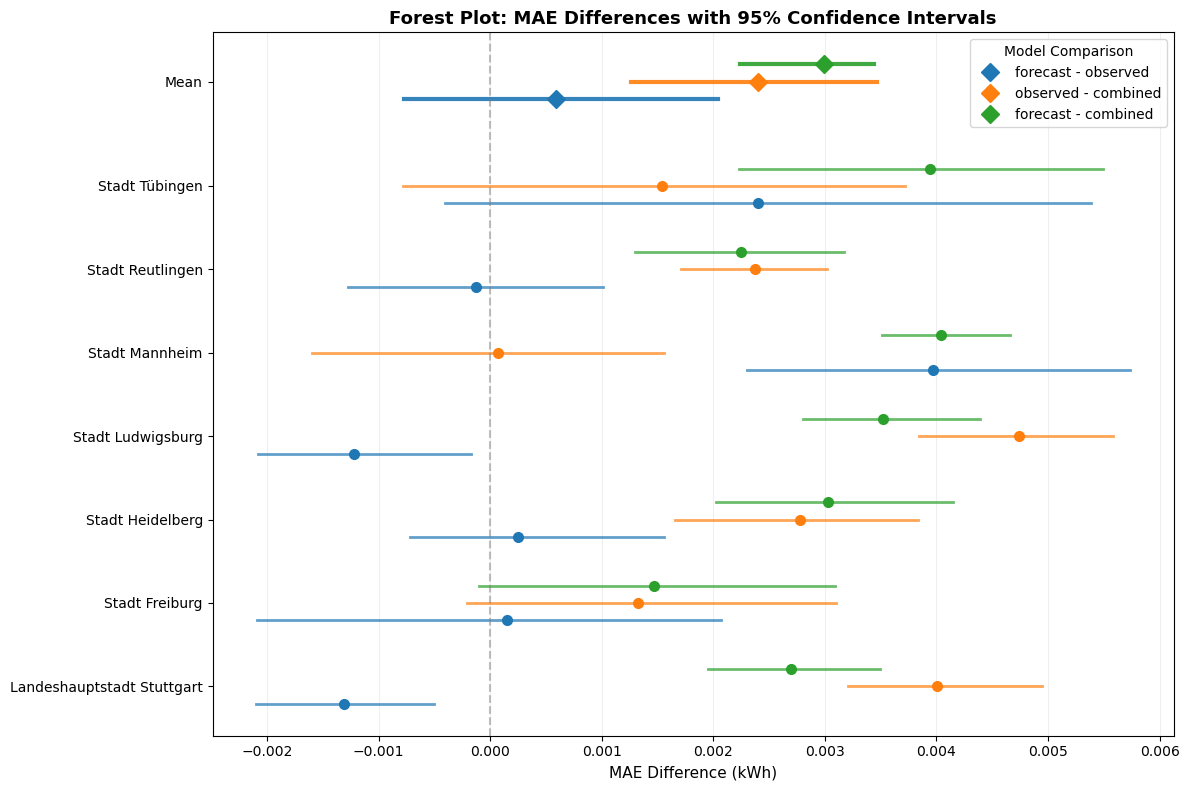

In [14]:
# Forest Plot mit Vergleichen nebeneinander pro Stadt erstellen
fig, ax = plt.subplots(figsize=(12, 8))

# Farben für die verschiedenen Vergleiche
colors = {'forecast - observed': '#1f77b4', 
          'observed - combined': '#ff7f0e', 
          'forecast - combined': '#2ca02c'}

comparisons = ['forecast - observed', 'observed - combined', 'forecast - combined']
cities = bootstrap_df['city'].unique()

y_position = 0
y_ticks = []
y_labels = []
offset = 0.25  # Abstand zwischen den Vergleichen pro Stadt

for city in cities:
    y_labels.append(city)
    city_middle = y_position + offset
    y_ticks.append(city_middle)
    
    for i, comparison in enumerate(comparisons):
        row = bootstrap_df[(bootstrap_df['city'] == city) & 
                          (bootstrap_df['model_comparison'] == comparison)].iloc[0]
        
        y_pos = y_position + i * offset
        
        # Konfidenzintervall
        ax.plot([row['CI_lower'], row['CI_upper']], [y_pos, y_pos], 
                color=colors[comparison], linewidth=2, alpha=0.7)
        # Punkt für MAE Differenz
        ax.plot(row['MAE_difference'], y_pos, 'o', 
                color=colors[comparison], markersize=7)
    
    y_position += 1.2  # Abstand zwischen Städten

# Mean über alle Städte
y_position += 0.3
y_ticks.append(y_position + offset)
y_labels.append('Mean')

for i, comparison in enumerate(comparisons):
    mean_data = mean_differences_df[mean_differences_df['model_comparison'] == comparison].iloc[0]
    
    y_pos = y_position + i * offset
    
    ax.plot([mean_data['CI_lower'], mean_data['CI_upper']], [y_pos, y_pos], 
            color=colors[comparison], linewidth=3, alpha=0.9)
    ax.plot(mean_data['mean_MAE_difference'], y_pos, 'D', 
            color=colors[comparison], markersize=9, label=comparison)

# Nulllinie
ax.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

# Achsen formatieren
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels, fontsize=10)
ax.set_xlabel('MAE Difference (kWh)', fontsize=11)
ax.set_title('Forest Plot: MAE Differences with 95% Confidence Intervals', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10, title='Model Comparison')
ax.grid(axis='x', alpha=0.2)

plt.tight_layout()
plt.show()